# Soft Actor Critic Implementation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import gymnasium as gym
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

from policy import CategoricalPolicy, GaussianPolicy
from network_utils import build_mlp, np2torch

In [11]:
class SoftActorCritic(nn.Module):
    def __init__(self, obs_dim, act_dim, lr=3e-4, r_scale=5, gamma = 0.99, tau=0.005, max_buffer_size=1e6, default_batch_size=256):
        nn.Module.__init__(self)

        self.obs_dim = obs_dim
        self.act_dim = act_dim

        self.lr = lr
        self.r_scale = r_scale
        self.gamma = gamma
        self.tau = tau

        self.default_batch_size = default_batch_size

        # self.device = torch.device("mps" if torch.backends.mps.is_available else "cpu")

        self.value = build_mlp(obs_dim, 1, 2, 256)
        self.value_optimizer = optim.Adam(self.value.parameters(), lr=self.lr)

        self.value_average = build_mlp(obs_dim, 1, 2, 256)

        self.q1 = build_mlp(obs_dim + act_dim, 1, 2, 256)
        self.q1_optimizer = optim.Adam(self.q1.parameters(), lr=self.lr)

        self.q2 = build_mlp(obs_dim + act_dim, 1, 2, 256)
        self.q2_optimizer = optim.Adam(self.q2.parameters(), lr=self.lr)

        self.network = build_mlp(obs_dim, act_dim, 2, 256)
        self.policy = GaussianPolicy(self.network, self.act_dim)
        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=self.lr)

        # In the form of (s_t, a_t, r(s_t, a-t), s_{t+1})
        self.replay_buffer = []
        self.max_buffer_size = max_buffer_size

    # Accpting input as torch
    def forward(self, obs):
        dist = self.policy.action_distribution(obs)
        return torch.tanh(dist.sample())

    def bulk_add_to_replay_buffer(self, lst):
        # self.replay_buffer = torch.cat((self.replay_buffer, torch.tensor(lst,
        # dtype=torch.float32)), 0)
        self.replay_buffer += lst

    def add_to_replay_buffer(self, obs, action, reward, next_obs, done):
        # self.replay_buffer = torch.cat((self.replay_buffer, torch.tensor([obs, action, reward, next_obs, done], dtype=torch.float32)), 0) 
        self.replay_buffer.append((torch.tensor(obs, dtype=torch.float32), torch.tensor(action, dtype=torch.float32), torch.tensor(reward,
        dtype=torch.float32), torch.tensor(next_obs, dtype=torch.float32), torch.tensor(done, dtype=torch.float32)))
        
        # self.replay_buffer.append((np2torch(obs), np2torch(action), np2torch(reward), np2torch(next_obs), np2torch(done)))

        # Only periodically cap to avoid thrashing
        if (len(self.replay_buffer) > self.max_buffer_size):
            # self.replay_buffer = self.replay_buffer[1:]
            self.replay_buffer = self.replay_buffer[:-self.default_batch_size * 5]

    def get_replay_batch(self, batch_size=256):
        batch_size = min(batch_size, len(self.replay_buffer))
        
        if (batch_size == -1):
            batch_size = len(self.replay_buffer)
        if (batch_size == 0):
            return (None, None, None, None, None)

        batch = random.sample(self.replay_buffer, batch_size)
        s = torch.stack([x[0] for x in batch])
        a = torch.stack([x[1] for x in batch])
        r = torch.stack([x[2] for x in batch])
        s_ = torch.stack([x[3] for x in batch])
        d = torch.stack([x[4] for x in batch])
        return s, a, r, s_, d

    def update_value(self):
        self.value_optimizer.zero_grad()

        s, a, r, s_, d = self.get_replay_batch()

        # s = self.replay_buffer[:, 0]
        # a = self.replay_buffer[:, 1]

        v = self.value(s)
        dist = self.policy.action_distribution(s)

        q_ = torch.min(self.q1(torch.cat((s, a), 1)), self.q2(torch.cat((s, a), 1)))
        
        loss = torch.mean(torch.square(v - q_ + self.r_scale * dist.log_prob(a)))

        loss.backward()
        self.value_optimizer.step()

    def update_q(self, n = 1):
        if (n == 1):
            q = self.q1
            q_optimizer = self.q1_optimizer
        else:
            q = self.q2
            q_optimizer = self.q2_optimizer
        
        print(q, self.q1, self.q2)

        q_optimizer.zero_grad()

        s, a, r, s_, d = self.get_replay_batch()

        q_ = q(torch.cat((s, a), 1))

        loss = torch.mean(torch.square(q_ - r - self.gamma * self.value_average(s_)))

        loss.backward() 
        q_optimizer.step()

    def update_q1(self):
        self.q1_optimizer.zero_grad()

        s, a, r, s_, d = self.get_replay_batch()

        q_ = self.q1(torch.cat((s, a), 1))

        loss = torch.mean(torch.square(q_ - r - self.gamma * self.value_average(s_)))

        loss.backward() 
        self.q1_optimizer.step()

    def update_q2(self):
        self.q2_optimizer.zero_grad()

        s, a, r, s_, d = self.get_replay_batch()

        q_ = self.q2(torch.cat((s, a), 1))

        loss = torch.mean(torch.square(q_ - r - self.gamma * self.value_average(s_)))

        loss.backward() 
        self.q2_optimizer.step()

    def update_policy(self):
        self.policy_optimizer.zero_grad()

        s, a, r, s_, d = self.get_replay_batch()

        # s = self.replay_buffer[:, 0]
        dist = self.policy.action_distribution(s)
        a = dist.rsample()

        q_ = torch.min(self.q1(torch.cat((s, a), 1)), self.q2(torch.cat((s, a), 1)))

        loss = torch.mean(self.r_scale * dist.log_prob(a) - q_)

        loss.backward()
        self.policy_optimizer.step()

    def update_q_average(self):
        with torch.no_grad():
            for param, param_avg in zip(self.value.parameters(), self.value_average.parameters()):
                param_avg.data.copy_(self.tau * param.data + (1 - self.tau) * param_avg.data)


In [12]:
env = gym.make('Ant-v4')
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

# Define your Soft Actor-Critic agent
agent = SoftActorCritic(obs_dim, act_dim)

gradient_steps = 1
rewards = []

# Training loop
def train(num_episodes, max_steps):
    # progress_bar = tqdm(total=num_episodes * max_steps, desc="Training", unit="step")

    for episode in tqdm(range(num_episodes)):
        obs = env.reset()[0]
        done = False
        episode_reward = 0

        # Collect trajectory data into replay buffer
        # TODO: should replay buffer be a set or a list?
        for step in range(max_steps):
            obs_ = torch.tensor(obs, dtype=torch.float32)
            # obs_ = np2torch(obs)
            action = agent(obs_).detach().numpy()

            next_obs, reward, done, info, _ = env.step(action)
            
            agent.add_to_replay_buffer(obs, action, reward, next_obs, done)

            obs = next_obs
            episode_reward += reward

            # progress_bar.update(1)

            if done:
                break

        # print(f"Episode {episode+1}: Reward = {episode_reward}")
        rewards.append(episode_reward)

        # Now do a bunch of gradient steps
        for step in range(gradient_steps):
            agent.update_value()
            # agent.update_q(n=1)
            # agent.update_q(n=2)
            agent.update_q1()
            agent.update_q2()
            agent.update_policy()
            agent.update_q_average()
    
    # progress_bar.close()
    

# Run the training loop
train(num_episodes=200, max_steps=1000)

100%|██████████| 200/200 [01:20<00:00,  2.48it/s]


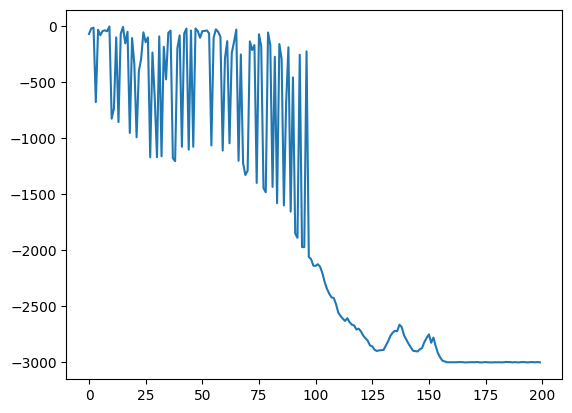

In [13]:
plt.plot(rewards)
plt.show()